In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader

import torchvision.transforms as T
from torchvision import datasets

# 0. Импорт датасета

In [ ]:
 ! pip install -q kaggle

ERROR: Operation cancelled by user


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"frlfff","key":"9c6c6f8af47b773314488731142adf7f"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d gpiosenka/time-image-datasetclassification

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/time-image-datasetclassification
License(s): CC0-1.0
 99% 380M/383M [00:13<00:00, 24.7MB/s]
100% 383M/383M [00:13<00:00, 29.3MB/s]


In [ ]:
import shutil
shutil.unpack_archive("/content/time-image-datasetclassification.zip",
                      "/content/time-image-datasetclassification")

# 1. Чтение и анализ данных

In [ ]:
df = pd.read_csv('/content/time-image-datasetclassification/clocks.csv')

In [ ]:
df

,class index,filepaths,labels,data set
0,0,train/1-00/0.jpg,1_00,train
1,0,train/1-00/1.jpg,1_00,train
2,0,train/1-00/11.jpg,1_00,train
3,0,train/1-00/12.jpg,1_00,train
4,0,train/1-00/13.jpg,1_00,train
...,...,...,...,...
14395,143,valid/9-55/65.jpg,9_55,valid
14396,143,valid/9-55/74.jpg,9_55,valid
14397,143,valid/9-55/88.jpg,9_55,valid
14398,143,valid/9-55/90.jpg,9_55,valid


In [ ]:
print(f"Количество классов: {df['labels'].unique().shape[0]}")

Количество классов: 144


Проверим баланс классов

In [ ]:
print('Train data')
for label in df['labels'].unique():
    result = df[(df['filepaths'].str.startswith('train')) & (df['labels'] == label)]
    print(f"\t{label}: {result.shape[0]}")

print('Validate data')
for label in df['labels'].unique():
    result = df[(df['filepaths'].str.startswith('valid')) & (df['labels'] == label)]
    print(f"\t{label}: {result.shape[0]}")

Train data
	1_00: 80
	1_05: 80
	1_10: 80
	1_15: 80
	1_20: 80
	1_25: 80
	1_30: 80
	1_35: 80
	1_40: 80
	1_45: 80
	1_50: 80
	1_55: 80
	10_00: 80
	10_05: 80
	10_10: 80
	10_15: 80
	10_20: 80
	10_25: 80
	10_30: 80
	10_35: 80
	10_40: 80
	10_45: 80
	10_50: 80
	10_55: 80
	11_00: 80
	11_05: 80
	11_10: 80
	11_15: 80
	11_20: 80
	11_25: 80
	11_30: 80
	11_35: 80
	11_40: 80
	11_45: 80
	11_50: 80
	11_55: 80
	12_00: 80
	12_05: 80
	12_10: 80
	12_15: 80
	12_20: 80
	12_25: 80
	12_30: 80
	12_35: 80
	12_40: 80
	12_45: 80
	12_50: 80
	12_55: 80
	2_00: 80
	2_05: 80
	2_10: 80
	2_15: 80
	2_20: 80
	2_25: 80
	2_30: 80
	2_35: 80
	2_40: 80
	2_45: 80
	2_50: 80
	2_55: 80
	3_00: 80
	3_05: 80
	3_10: 80
	3_15: 80
	3_20: 80
	3_25: 80
	3_30: 80
	3_35: 80
	3_40: 80
	3_45: 80
	3_50: 80
	3_55: 80
	4_00: 80
	4_05: 80
	4_10: 80
	4_15: 80
	4_20: 80
	4_25: 80
	4_30: 80
	4_35: 80
	4_40: 80
	4_45: 80
	4_50: 80
	4_55: 80
	5_00: 80
	5_05: 80
	5_10: 80
	5_15: 80
	5_20: 80
	5_25: 80
	5_30: 80
	5_35: 80
	5_40: 80
	5_45: 80
	5_50: 80
	5_

Баланс классов соблюдается

Проверим, одинаковый ли размер у всех изображений

In [ ]:
all_different_sizes = set()

for path in df['filepaths']:
    full_path = '/content/time-image-datasetclassification/' + path

    all_different_sizes.add(Image.open(full_path).size)

all_different_sizes

{(224, 224)}

Таким образом, все изображения имеют одинаковый размер.

In [ ]:
# сохраним пути

train_filepaths = []
val_filepaths = []
test_filepaths = []

for path in df['filepaths'].to_numpy():
    key = path.split('/')[0]
    if key == 'train':
        train_filepaths.append('/content/time-image-datasetclassification/' + path)
    if key == 'valid':
        val_filepaths.append('/content/time-image-datasetclassification/' + path)
    if key == 'test':
        test_filepaths.append('/content/time-image-datasetclassification/' + path)

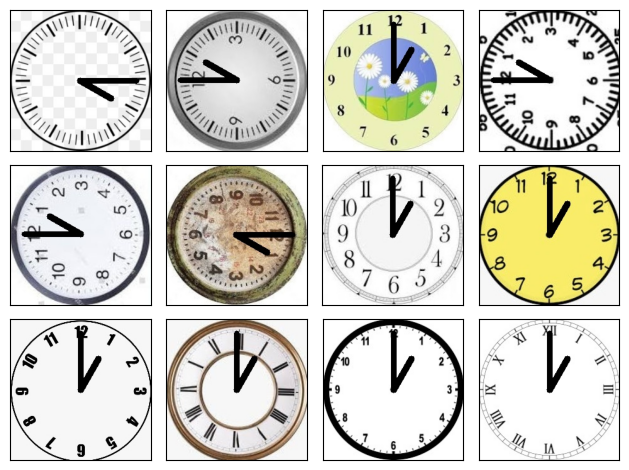

In [ ]:
# посмотрим примеры изображений
fig, axes = plt.subplots(3, 4)

i = 0; j = 0
for path in train_filepaths[:12]:
    axes[i][j].imshow(Image.open(path))
    axes[i][j].get_xaxis().set_visible(False)
    axes[i][j].get_yaxis().set_visible(False)

    if j == 3:
        j = 0; i += 1
    else:
        j += 1

plt.tight_layout()
plt.show()

Видно, что на изображениях присутствуют повороты, а также некоторые изображения нельзя классифицировать однозначно (нету циферблата)  

# 2. Подготовка данных и модели

In [ ]:
# переводим данные в тензорный датасет
train_dataset = datasets.ImageFolder('/content/time-image-datasetclassification/train', transform=T.ToTensor())
val_dataset = datasets.ImageFolder('/content/time-image-datasetclassification/valid', transform=T.ToTensor())
test_dataset = datasets.ImageFolder('/content/time-image-datasetclassification/test', transform=T.ToTensor())

In [ ]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

11520 1440 1440


In [ ]:
batch_size = 96 # размер пакета

In [ ]:
# загрузчики данных
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

In [ ]:
import torchvision.models as models

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.IMAGENET1K_V1')
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 126MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
! pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 1000]                 --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

In [ ]:
# изменим число классов с 1000 на 144
model.classifier[1] = nn.Linear(1280, 144)

In [ ]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 144]                  --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
! pip install pytorch-ignite --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 60.5 MB/s eta 0:00:00


In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [ ]:
metrics = {
    "loss": Loss(criterion),
    "accuracy": Accuracy(),
    "cm": ConfusionMatrix(num_classes=144)
}

In [ ]:
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
test_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [ ]:
training_history = {'accuracy': [], 'loss': []}
test_history = {'accuracy': [], 'loss': []}
last_epoch = []

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']*100
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {} Сред. точность: {:.2f} Сред. ошибка {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']*100
    last_epoch.append(0)
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {} Сред. точность: {:.2f} Сред. ошибка {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
breaker = EarlyStopping(patience=10, score_function=lambda engine: engine.state.metrics['accuracy'],
                        trainer=trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker)

In [ ]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name='accuracy',
    global_step_transform=global_step_from_engine(trainer)
)
test_evaluator.add_event_handler(Events.COMPLETED, saver)

In [ ]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True, bar_format='')
pbar.attach(trainer, output_transform=lambda x: {"loss" : x})

In [ ]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = train_dataset.classes
    fig, ax = plt.subplots(figsize=(10, 10))
    ax=plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='d')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion matrix')
    ax.xaxis.set_ticklabels(classes, rotation=90)
    ax.yaxis.set_ticklabels(classes, rotation=0)

  1%|          | 1/120 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1 Сред. точность: 79.22 Сред. ошибка 59.40301
Результат обучения - Эпоха: 1 Сред. точность: 79.58 Сред. ошибка 59.02735


  1%|          | 1/120 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2 Сред. точность: 96.97 Сред. ошибка 10.20301
Результат обучения - Эпоха: 2 Сред. точность: 96.88 Сред. ошибка 11.38816


  1%|          | 1/120 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3 Сред. точность: 99.62 Сред. ошибка 1.89358
Результат обучения - Эпоха: 3 Сред. точность: 99.38 Сред. ошибка 2.67734


  1%|          | 1/120 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4 Сред. точность: 98.54 Сред. ошибка 6.74888
Результат обучения - Эпоха: 4 Сред. точность: 98.33 Сред. ошибка 7.52852


  1%|          | 1/120 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5 Сред. точность: 98.44 Сред. ошибка 4.84743
Результат обучения - Эпоха: 5 Сред. точность: 98.06 Сред. ошибка 6.07117


ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: The number of FixedLocator locations (36), usually from a call to set_ticks, does not match the number of labels (144).


State:
	iteration: 600
	epoch: 5
	epoch_length: 120
	max_epochs: 5
	output: 0.05276696756482124
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

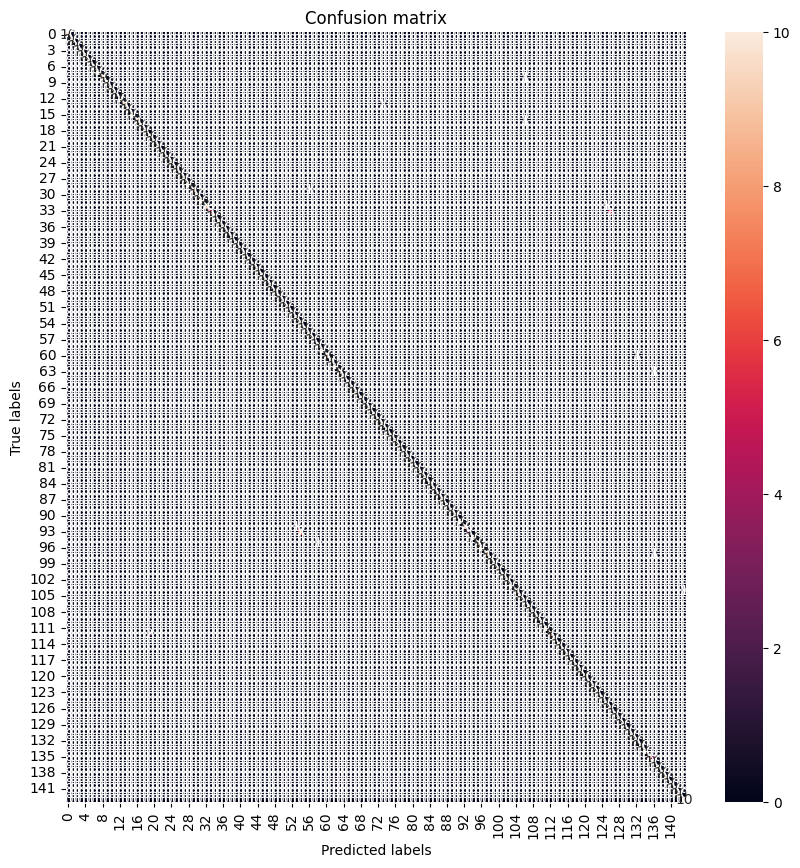

In [ ]:
trainer.run(train_loader, max_epochs=5)

Видно, что нейросеть смогла обучиться на предоставленных данных и дала хорошую точность.